# Original ligands

## Aim of this notebook

Based on the fragment library, get all ligands from which these fragments originated from ("original ligands" from KLIFS dataset).

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

import klifs_utils
from utils import read_fragment_library, get_original_ligands, standardize_mol

In [4]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [5]:
PATH_DATA = Path('.') / '..' / 'data'

## Load fragment library

`fragment_library` is a dictionary containing a `pandas` DataFrame for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the pool X.

The following data is linked to each fragment:

- `ROMol`, `ROMol_dummy`, and `ROMol_original`: RDKit molecules for the 2D representation of the fragment without and with dummy atoms as well as for the 3D representation of the fragment as described in the SDF file from which the data is loaded.
- `kinase`, `family`, and `group`: *Kinase* name, *family* and *group* of the kinase that the ligand (from which the fragment originates) was co-crystallized with
- `complex_pdb`, `ligand_pdb`, `alt`, and `chain`: *PDB complex* and *ligand ID*, *alternate model* and *chain* for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- `atom_subpockets`: Subpocket assignment for each of the fragment's atoms
- `atom_environments`: BRICS environment IDs for each of the fragment's atoms
- `smiles` and `smiles_dummy`: SMILES for the fragment without and with dummy atoms
- `subpocket`: Subpocket assignment for the fragment

1. Load fragments per subpocket (from SDF files)

In [6]:
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

2. Concatenate subpocket pools

In [7]:
fragment_library_concat = pd.concat(fragment_library.values())

(7486, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,AP
1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,AP

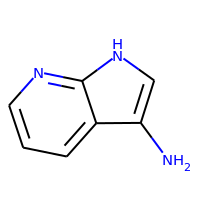
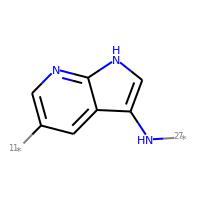
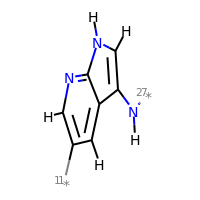
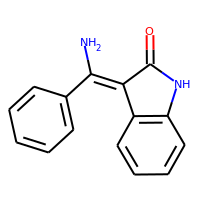
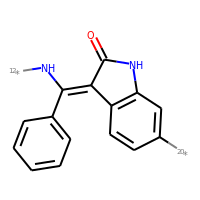
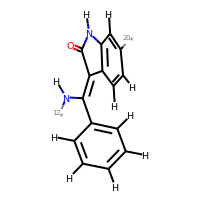

In [8]:
print(fragment_library_concat.shape)
fragment_library_concat.head(2)

## Get original ligands from fragment library

Group fragment library by ligand: For each ligand collect the following data:

- PDB complex and ligand ID, alternate model, chain, and aC-helix conformation for the KLIFS structure that the ligand was co-crystallized with
- Kinase name, family, and group of the kinase the ligand was co-crystallized with
- Subpockets occupied by the ligand
- Ligand RDKit molecule (remote KLIFS access) and SMILES (generated from RDKit molecule)

In [9]:
# Takes a couple of minutes (queries KLIFS database)
original_ligands = get_original_ligands(fragment_library_concat)

(2553, 11)


,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,ROMol,smiles
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1

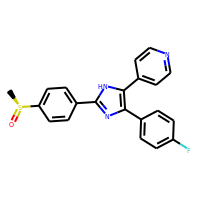
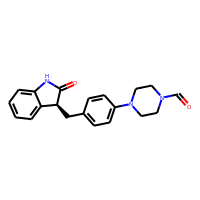

In [10]:
print(original_ligands.shape)
original_ligands.head(2)

## Add standardized molecule (InChI) 

This will come in handy later when we compare recombined ligands with the original KLIFS ligands.

In [11]:
original_ligands['inchi'] = original_ligands.apply(lambda x: Chem.MolToInchi(standardize_mol(x.ROMol)), axis=1)

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,ROMol,smiles,inchi
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...

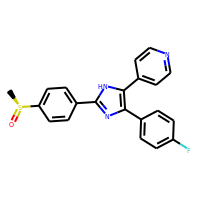
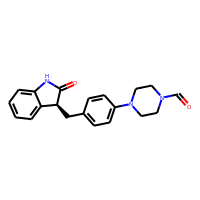

In [12]:
original_ligands.head(2)

## Save original ligands to file

In [14]:
original_ligands.drop('ROMol', axis=1).to_json(PATH_DATA / 'fragment_library' / 'original_ligands.json')